In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
plt.rcParams['figure.dpi'] = 120 # Adjusting figure size

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.utils import plot_model

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [5]:
bit_file = 'bitcoin_updated.csv'
ether_file = 'ethereum_updated.csv'

In [6]:
def process(file):
    df = pd.read_csv(file, header=0)
    df['Time'] = pd.to_datetime(df['Date'])
    df.drop(columns=['Date'], inplace=True)
    columns = ['Open*','High','Low','Close**','Volume', 'Market Cap']
    df = df[['Time','Open*','High','Low','Volume', 'Market Cap','Close**']]
    
    for col in columns:
        df[col] = df[col].str.replace(',', '').astype(float)
        #df[col] = df[col].replace(astype(float))
    df = df.sort_values(by='Time').set_index('Time')
    return df

In [27]:
df = process(ether_file)
df = df[['Close**']]
train_df = df[:-10].copy()
test_df = df[-10:].copy()
train, test = train_df.values, test_df.values
    
train = np.reshape(train, (len(train), 1))
scale = MinMaxScaler()
train = scale.fit_transform(train)
x_train, y_train = train[0:len(train)-1], train[1:len(train)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))
#df.plot(figsize=(15,5), title="Closing Price")    

In [28]:
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=50)

Epoch 1/100
39/39 [==============================] - 0s 2ms/step - loss: 0.2746
Epoch 2/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0713
Epoch 3/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0627
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 5/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0539
Epoch 6/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0517
Epoch 7/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0511
Epoch 8/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0487
Epoch 9/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 10/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0424
Epoch 11/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0398
Epoch 12/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 13/100
39/39 [=================

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [12]:
plot_model(model, to_file='model.pdf')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [30]:
x_test = np.reshape(test, (len(test),1))
x_test = scale.transform(x_test)
x_test = np.reshape(x_test, (len(x_test),1,1))
y_pred = model.predict(x_test)
y_pred = scale.inverse_transform(y_pred)

In [31]:
test_df['Close_pred'] = y_pred
data = pd.concat([test_df, train_df], sort=False)

In [32]:
train_pred = model.predict(x_train)
train_pred = scale.inverse_transform(train_pred)

In [33]:
y_true = scale.inverse_transform(y_train)

<AxesSubplot:xlabel='Time'>

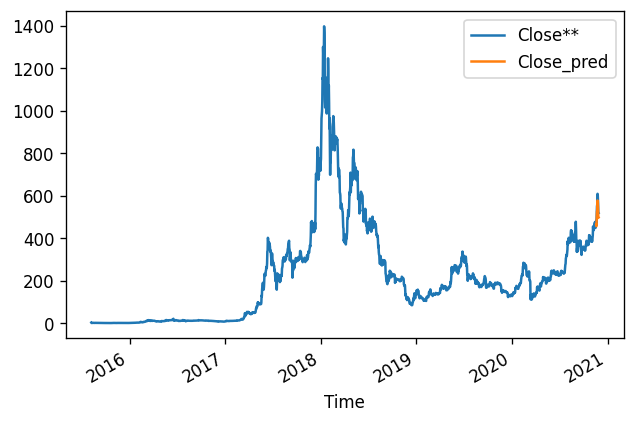

In [34]:
data.plot()

<AxesSubplot:xlabel='Time'>

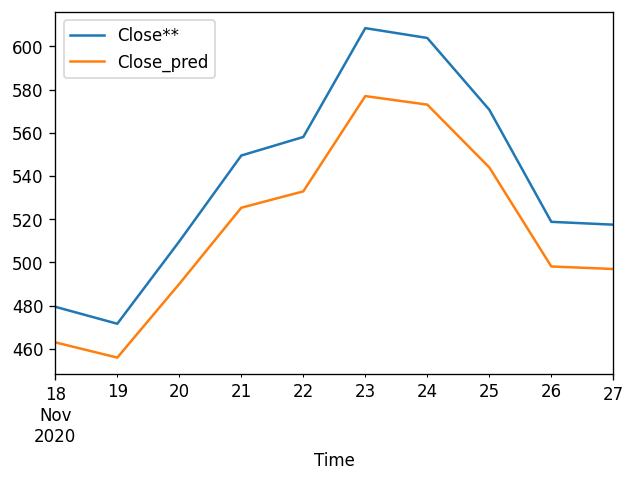

In [35]:
test_df.plot()

In [36]:
test_df['noise'] = np.random.normal(0, 10, len(test_df))

In [37]:
test_df['pred'] = test_df['Close_pred']+test_df['noise']

<AxesSubplot:xlabel='Time'>

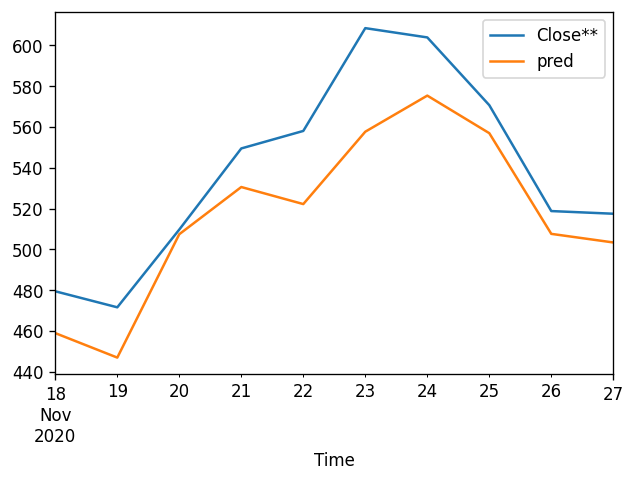

In [38]:
test_df[['Close**', 'pred']].plot()

In [21]:
test_df['rolling'] = test_df['pred'].rolling(window=2).mean()

<AxesSubplot:xlabel='Time'>

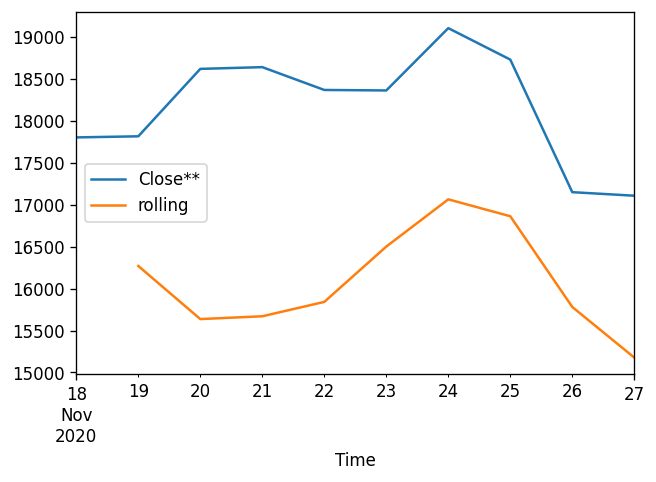

In [22]:
test_df[['Close**', 'rolling']].plot()

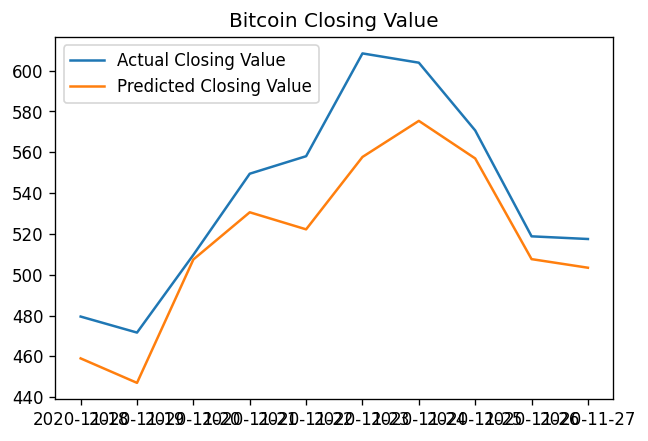

In [39]:
plt.plot(test_df['Close**'], label="Actual Closing Value")
plt.plot(test_df['pred'], label="Predicted Closing Value")
plt.title("Bitcoin Closing Value")
plt.legend()
plt.savefig('lstm_ether_close_10.pdf')

In [126]:
def test_stationarity(timeseries,lag):
    
    #Determing rolling statistics
    #pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()   #moving average
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = lag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

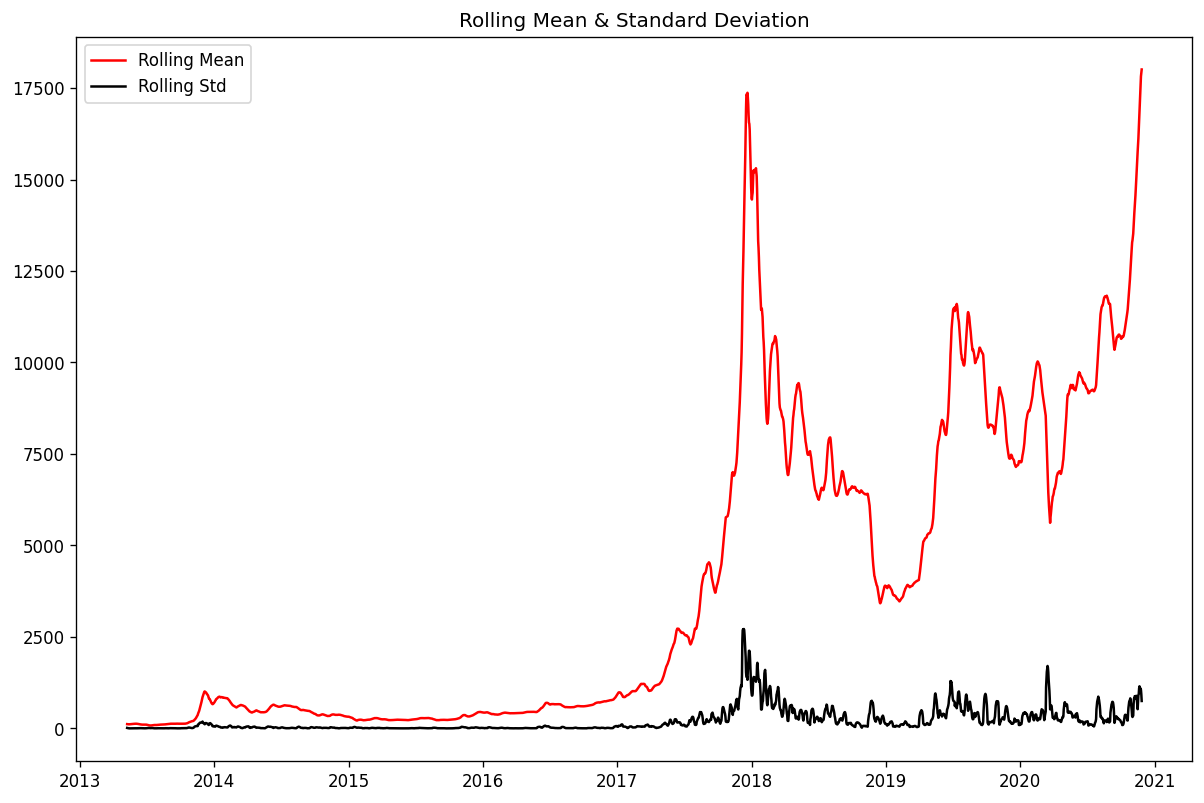

Results of Dickey-Fuller Test:
Test Statistic                   -0.571206
p-value                           0.877356
#Lags Used                       27.000000
Number of Observations Used    2743.000000
Critical Value (1%)              -3.432736
Critical Value (5%)              -2.862594
Critical Value (10%)             -2.567331
dtype: float64


In [134]:
test_stationarity(df, 'AIC')

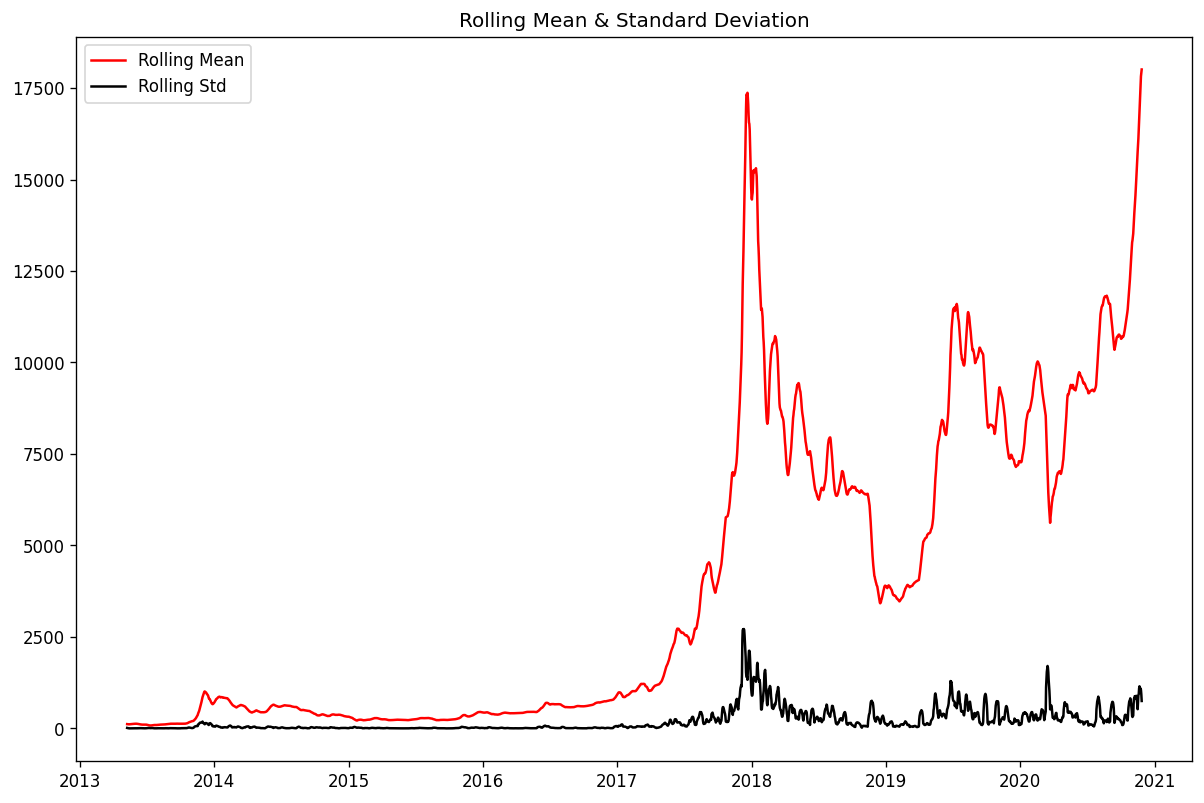

Results of Dickey-Fuller Test:
Test Statistic                   -0.258163
p-value                           0.931224
#Lags Used                        0.000000
Number of Observations Used    2770.000000
Critical Value (1%)              -3.432713
Critical Value (5%)              -2.862584
Critical Value (10%)             -2.567326
dtype: float64


In [135]:
test_stationarity(df, 'BIC')

In [142]:
dc = seasonal_decompose(df, freq=2, extrapolate_trend = 1)

/home/priya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


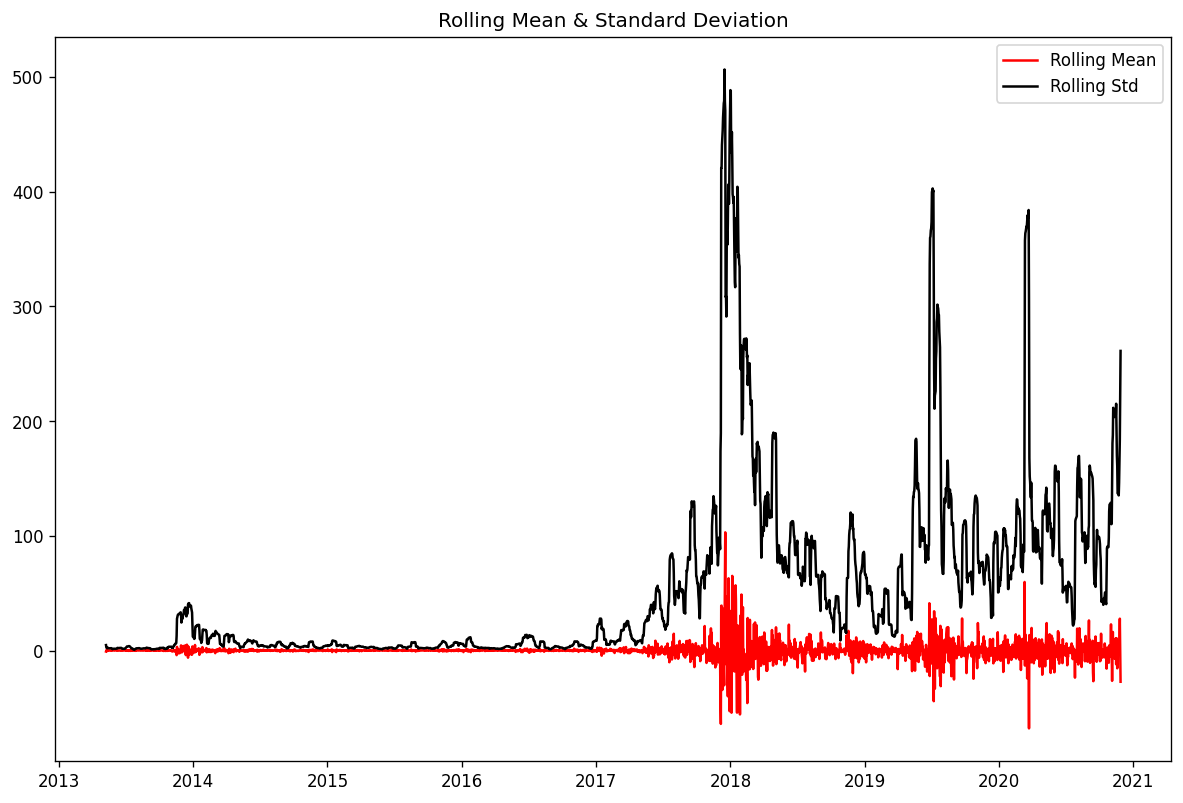

Results of Dickey-Fuller Test:
Test Statistic                  -22.762226
p-value                           0.000000
#Lags Used                       18.000000
Number of Observations Used    2752.000000
Critical Value (1%)              -3.432728
Critical Value (5%)              -2.862591
Critical Value (10%)             -2.567329
dtype: float64


In [145]:
test_stationarity(dc.observed-dc.trend-dc.seasonal, 'BIC')